In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.tri as tri
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import scale
from statsmodels.base.model import GenericLikelihoodModel
%matplotlib inline

In [2]:
pklfile = '../learn/pkl_trainsets/19aug2019_opusupdate/mlecompare_not-scaled_15nuc.pkl'
XY = pd.read_pickle(pklfile)
XY.reset_index(inplace=True, drop=True)
if 'total' in XY.columns:
    XY.drop('total', axis=1, inplace=True)
lbls = ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']

In [3]:
### filter trainXY ###
#Need to explicitly tell pandas not to worry that I'm making a copy
trainXY = XY.loc[XY['Burnup'] > 0].copy()
trainXY = trainXY.sample(frac=0.15)
trainXY.shape

(10972, 20)

In [4]:
def splitXY(dfXY):
    lbls = ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']
    dfX = dfXY.drop(lbls, axis=1)
    r_dfY = dfXY.loc[:, lbls[0]]
    c_dfY = dfXY.loc[:, lbls[1]]
    e_dfY = dfXY.loc[:, lbls[2]]
    b_dfY = dfXY.loc[:, lbls[3]]
    o_dfY = dfXY.loc[:, lbls[4]]
    return dfX, r_dfY, c_dfY, e_dfY, b_dfY, o_dfY

X, rY, cY, eY, bY, oY = splitXY(trainXY)

In [11]:
trainXY.sample(10)

,Burnup,CoolingTime,Enrichment,OrigenReactor,ReactorType,ba136,ba138,cs133,cs134,cs135,cs137,eu153,eu154,pu239,pu240,pu241,pu242,sm149,sm150,sm152
70985,7621.38,3270.898620,0.711,candu37,phwr,0.006121,2.3170,2.2850,0.001314,0.61860,1.7250,0.074430,0.002673,5.967,0.89770,0.085570,0.009831,0.009979,0.37550,0.21730
64593,2344.12,4670.129389,0.711,candu37,phwr,0.000974,0.7178,0.7106,0.000031,0.20190,0.4896,0.018480,0.000191,2.303,0.09842,0.002435,0.000087,0.010960,0.10550,0.05306
57629,5778.67,61.232556,0.711,candu19,phwr,0.003613,1.7640,1.7420,0.013220,0.47500,1.6060,0.051250,0.003077,4.679,0.46100,0.044660,0.002231,0.010910,0.27820,0.16000
43551,1604.81,4903.026823,3.630,agr,agr,0.000871,0.4858,0.4849,0.000025,0.21820,0.3285,0.013580,0.000126,2.712,0.14250,0.006141,0.000205,0.010650,0.07055,0.03019
59790,8282.21,1601.145687,0.711,candu19,phwr,0.006649,2.5200,2.4830,0.006795,0.66070,2.0810,0.080780,0.004491,6.106,0.89530,0.100600,0.009612,0.010600,0.40660,0.23950
426,946.26,4288.266818,3.100,ce14x14,pwr,0.000358,0.2850,0.2849,0.000012,0.06958,0.2010,0.007911,0.000053,2.252,0.04941,0.001546,0.000023,0.014230,0.03359,0.01605
4311,4708.95,2815.125153,3.100,ce14x14,pwr,0.004111,1.4010,1.3950,0.001628,0.33480,1.0940,0.051540,0.001889,8.697,0.86270,0.150400,0.009382,0.017160,0.22910,0.11610
63202,1379.90,662.422958,0.711,candu37,phwr,0.000478,0.4231,0.4191,0.000388,0.12080,0.3717,0.010510,0.000160,1.414,0.03426,0.000845,0.000010,0.011040,0.05738,0.02698
57817,5778.67,1862.303821,0.711,candu19,phwr,0.003625,1.7640,1.7420,0.002527,0.47500,1.4340,0.051250,0.002068,4.678,0.46080,0.035160,0.002231,0.010910,0.27820,0.16000
24122,7759.88,698.121617,2.990,vver1000,pwr,0.009646,2.2910,2.2700,0.030830,0.55390,2.0550,0.101500,0.008112,12.580,1.89200,0.678200,0.055220,0.018050,0.40030,0.20560


# ML Calculation
## Likelihoods of each observation calculated for a single comparison

In [5]:
### If random filtering: make sure sample isn't in training set ###
sim_idx = 43551
test_exist = trainXY.loc[trainXY.index == sim_idx]
test_exist

,Burnup,CoolingTime,Enrichment,OrigenReactor,ReactorType,ba136,ba138,cs133,cs134,cs135,cs137,eu153,eu154,pu239,pu240,pu241,pu242,sm149,sm150,sm152


In [6]:
test_sample = XY.loc[XY.index == sim_idx].drop(lbls, axis=1)
test_answer = XY.loc[XY.index == sim_idx, lbls]
test_answer
#test_sample

,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
43551,agr,4903.026823,3.63,1604.81,agr


In [7]:
def ll_calc(y_sim, y_mes, std):
    ll = np.sum(stats.norm.logpdf(y_sim, loc=y_mes, scale=std))
    return ll

def unc_calc(y_sim, y_mes, sim_unc_sq, mes_unc_sq):
    unc = ((y_sim - y_mes) / sim_unc_sq)**2 * (sim_unc_sq + mes_unc_sq)
    unc.replace([np.inf, -np.inf], 0, inplace=True)
    unc.fillna(0, inplace = True)
    return np.sqrt(unc.sum(axis=1))

In [8]:
row_unc = 0.14
test_unc = 0.14
trainXY['LogLikelihood'] = X.apply(lambda row: ll_calc(row, test_sample.iloc[0], row_unc), axis=1)
#############################################################################
# pandas converts each row to a series, so using .iloc[0] on the single-row #
# dataframe that is test_sample allows the function to work properly        #
#############################################################################

In [9]:
trainXY['LLUncertainty'] = X.apply(lambda row: unc_calc(row, test_sample.iloc[0], (row_unc*row)**2, (test_unc*test_sample)**2), axis=1)

In [10]:
trainXY.head(10)

,Burnup,CoolingTime,Enrichment,OrigenReactor,ReactorType,ba136,ba138,cs133,cs134,cs135,...,eu154,pu239,pu240,pu241,pu242,sm149,sm150,sm152,LogLikelihood,LLUncertainty
53175,2077.13,561.199381,0.711,candu19,phwr,0.000793,0.6370,0.6305,0.000967,0.1791,...,0.000360,1.925,0.06359,0.002073,0.000035,0.01101,0.09204,0.04600,-2.833648,209.596771
24840,8251.85,2740.784408,2.990,vver1000,pwr,0.010690,2.4340,2.4090,0.005325,0.5891,...,0.005849,13.000,2.04700,0.592100,0.067850,0.01853,0.42810,0.21970,-3049.666438,23.988939
16412,8696.70,3651.120960,3.690,ce14x14,pwr,0.012190,2.5550,2.5270,0.002746,0.6461,...,0.005839,13.530,2.13900,0.643600,0.087120,0.01948,0.45960,0.22830,-3371.151728,24.162110
27010,1829.59,4531.068813,3.740,vver1000,pwr,0.000987,0.5466,0.5468,0.000048,0.1366,...,0.000200,4.822,0.19920,0.012080,0.000355,0.01635,0.07666,0.03601,-98.384902,12.490608
10641,3189.70,1184.342996,3.690,ce14x14,pwr,0.002297,0.9499,0.9487,0.003471,0.2352,...,0.001310,7.028,0.48840,0.078920,0.002607,0.01706,0.14780,0.07205,-480.062024,19.284338
37844,4142.81,2502.737730,3.090,agr,agr,0.003838,1.2480,1.2420,0.001373,0.5539,...,0.001289,5.308,0.69190,0.094910,0.006294,0.01106,0.20200,0.09891,-207.888888,20.780246
28810,3991.84,2322.342085,3.740,vver1000,pwr,0.003439,1.1850,1.1820,0.001968,0.2980,...,0.001595,9.004,0.76860,0.131000,0.006300,0.01750,0.19080,0.09471,-1040.172386,20.919783
49038,7316.84,4531.157068,3.630,agr,agr,0.010640,2.1830,2.1650,0.000668,0.9925,...,0.002635,7.831,1.64600,0.314100,0.051890,0.01206,0.37410,0.19140,-912.597259,23.335563
60986,8464.38,3458.992343,0.711,candu19,phwr,0.006906,2.5750,2.5370,0.001290,0.6739,...,0.003112,6.198,0.93040,0.083530,0.010500,0.01059,0.41600,0.24520,-600.987885,23.004957
19492,2737.05,4486.575797,2.990,vver1000,pwr,0.001741,0.8186,0.8167,0.000111,0.1950,...,0.000422,6.113,0.37060,0.029820,0.001313,0.01623,0.12350,0.06011,-287.973303,16.604318


### Max LL: Reactor-dependent (paper presents it this way)

#### PWR

In [11]:
max_pwr = trainXY['LogLikelihood'].loc[trainXY['ReactorType'] == 'pwr'].max()
idx_pwr = trainXY['LogLikelihood'].loc[trainXY['ReactorType'] == 'pwr'].idxmax()
unc_pwr = float(trainXY['LLUncertainty'].loc[trainXY.index == idx_pwr])
print(f'Max Log Likelihood for PWRs: {max_pwr} +/- {unc_pwr}')
trainXY.loc[trainXY.index == idx_pwr, ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']]

Max Log Likelihood for PWRs: 12.549406481393513 +/- 320.52782369864667


,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
25563,pwr,81.549126,3.74,937.48,vver1000


#### AGR

In [12]:
max_agr = trainXY['LogLikelihood'].loc[trainXY['ReactorType'] == 'agr'].max()
idx_agr = trainXY['LogLikelihood'].loc[trainXY['ReactorType'] == 'agr'].idxmax()
unc_agr = float(trainXY['LLUncertainty'].loc[trainXY.index == idx_agr])
print(f'Max Log Likelihood for AGRs: {max_agr} +/- {unc_agr}')
trainXY.loc[trainXY.index == idx_agr, ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']]

Max Log Likelihood for AGRs: 15.707612547923361 +/- 0.14443199983925323


,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
43549,agr,4887.893062,3.63,1604.81,agr


#### PHWR

In [13]:
max_phwr = trainXY['LogLikelihood'].loc[trainXY['ReactorType'] == 'phwr'].max()
idx_phwr = trainXY['LogLikelihood'].loc[trainXY['ReactorType'] == 'phwr'].idxmax()
unc_phwr = float(trainXY['LLUncertainty'].loc[trainXY.index == idx_phwr])
print(f'Max Log Likelihood for PHWRs: {max_phwr} +/- {unc_phwr}')
trainXY.loc[trainXY.index == idx_phwr, ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']]

Max Log Likelihood for PHWRs: 8.229980587768885 +/- 51.78580412984669


,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
64630,phwr,5688.937199,0.711,2344.12,candu37


## LL wrt Burnup and Cool Time

In [14]:
min_ll = trainXY['LogLikelihood'].min()
med_ll = trainXY['LogLikelihood'].median()
mean_ll = trainXY['LogLikelihood'].mean()
max_ll = trainXY['LogLikelihood'].max()
min_ll, med_ll, mean_ll, max_ll

(-4472.5879283255235,
 -447.8598862638946,
 -863.0271906882383,
 15.707612547923361)

In [15]:
plotXY = trainXY.loc[trainXY['LogLikelihood'] > med_ll]
plotXY.shape, trainXY.shape

((5486, 22), (10972, 22))

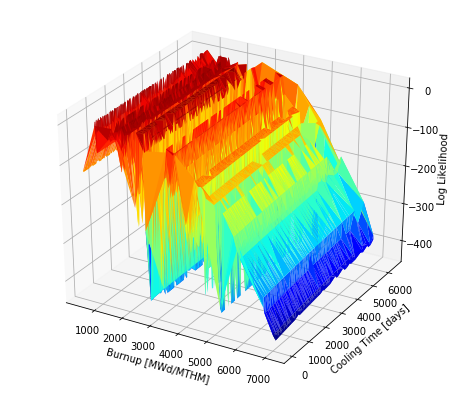

In [16]:
x = plotXY['Burnup']
y = plotXY['CoolingTime']
triang = tri.Triangulation(x, y)
z = plotXY['LogLikelihood']

fig = plt.figure(figsize=(8, 7))
ax = fig.gca(projection='3d')
ax.plot_trisurf(triang, z, linewidth=0.1, cmap='jet')
#ax.scatter(x, y, z)
ax.set_xlabel('Burnup [MWd/MTHM]')
ax.set_ylabel('Cooling Time [days]')
ax.set_zlabel('Log Likelihood')
plt.show()

# ML Estimation
## Coefficients of linear models estimated
This example is done with dependent variable = burnup

In [22]:
class NormMod(GenericLikelihoodModel):
    def __init__(self, endog, exog, **kwds):
        super(NormMod, self).__init__(endog, exog, **kwds)
    
    def nloglikeobs(self, params):
        beta = params
        yhat = np.dot(self.exog, beta)
        LL = stats.norm.logpdf(self.endog, loc=yhat)
        return -LL
    
    def fit(self, start_params=None, maxiter=100000, maxfun=100000, **kwds):
        if start_params == None:
            start_params = np.zeros(self.exog.shape[1])
            start_params[0] = np.log(self.endog.mean())
        return super(NormMod, self).fit(start_params=start_params,
                                        maxiter=maxiter, maxfun=maxfun,
                                        **kwds)

In [23]:
y = bY
X = sm.add_constant(X)

/home/opotowsky/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [24]:
X.shape

(14629, 16)

In [25]:
mod = NormMod(y, X)

In [26]:
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 27681.316033
         Iterations: 3281
         Function evaluations: 4470
                               NormMod Results                                
Dep. Variable:                 Burnup   Log-Likelihood:            -4.0495e+08
Model:                        NormMod   AIC:                         8.099e+08
Method:            Maximum Likelihood   BIC:                         8.099e+08
Date:                Mon, 26 Aug 2019                                         
Time:                        12:40:39                                         
No. Observations:               14629                                         
Df Residuals:                   14613                                         
Df Model:                          15                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------

/home/opotowsky/.local/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/opotowsky/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/opotowsky/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/opotowsky/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [27]:
test_sample.insert(0, 'const', 1.0)
burn_pred = np.sum(test_sample.iloc[0] * res.params)
burn_pred, test_answer['Burnup']

(1525.3473756144888, 43552    1604.81
 Name: Burnup, dtype: float64)